# Final Project

In [141]:
# import libraries (notice that we have included some new libraries that we will be using in this lab)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import scipy.stats as stat
import statsmodels.api as sm
import datetime
from numbers import Number
from decimal import Decimal

In [142]:
van_slev_file_name = 'data/VanHarbourSeaLevelData.csv'
van_temperature_file_name = 'data/VanHarbourTempData.csv'
tofino_slev_file_name = 'data/TofinoSeaLevelData.csv'
tofino_temperature_file_name = 'data/TofinoTempData.csv'

In [143]:
# Make dataframe for each day for the period of 1940-2021 for Vancouver Harbour and Tofino

start_date = "1950-01-01"
end_date = "2021-12-31"

date_range_str = " (1950-2021)" # For graph titles

date_range = pd.date_range(start=start_date, end=end_date, freq='D')
df_SOB_van = pd.DataFrame(date_range, columns=['Date'])
df_SOB_tofino = pd.DataFrame(date_range, columns=['Date'])


In [144]:
# Read in the Vancouver Harbour Data 
df_van_slev = pd.read_csv(van_slev_file_name, sep=',', parse_dates=['Date'])
df_van_slev = df_van_slev.set_index('Date')

df_van_temp = pd.read_csv(van_temperature_file_name, sep=',', parse_dates=['Date'])
df_van_temp = df_van_temp.set_index('Date')
# drop columns other than date and MeanTemp
df_van_temp = df_van_temp.drop(columns=['Unnamed: 0', 'Year', 'Month', 'Day', 'MaxTemp', 'MaxTempFlag',
       'MinTemp', 'MinTempFlag', 'MeanTempFlag', 'HeatDegDays',
       'HeatDegDaysFlag', 'CoolDegDays', 'CoolDegDaysFlag'])


# Read in the Tofino Data
df_tofino_slev = pd.read_csv(tofino_slev_file_name, sep=',', parse_dates=['Date'])
df_tofino_slev = df_tofino_slev.set_index('Date')

df_tofino_temp = pd.read_csv(tofino_temperature_file_name, sep=',', parse_dates=['Date'])
df_tofino_temp = df_tofino_temp.set_index('Date')


In [145]:
# Add the data to the SOB dataframe if the date matches
df_SOB_van = df_SOB_van.merge(df_van_slev, how='left', on='Date')
df_SOB_van = df_SOB_van.merge(df_van_temp, how='left', on='Date')

df_SOB_tofino = df_SOB_tofino.merge(df_tofino_slev, how='left', on='Date')
df_SOB_tofino = df_SOB_tofino.merge(df_tofino_temp, how='left', on='Date')

In [146]:
# Plot the time series for the data
def plot_daily_time_series(df, x_name, y_name, title, xlabel, ylabel):
    plt.figure(figsize=(15, 5))
    plt.plot(df[x_name], df[y_name], '-', color='black' )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    plt.savefig("graphs/" + "Daily_" + title[:(len(title)-12)] + '.png', dpi=300, bbox_inches="tight")

# Plot monthly time series
def plot_monthly_time_series(df, x_name, y_name, title, xlabel, ylabel):
    df_monthly = df.groupby(pd.Grouper(key=x_name, freq='M')).mean()
    plt.figure(figsize=(15, 5))
    plt.plot(df_monthly.index, df_monthly[y_name], '-', color='black' )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    plt.savefig("graphs/" + "Monthly_ " + title[:(len(title)-12)] + '.png', dpi=300, bbox_inches="tight")


# Plot Yearly time series
def plot_yearly_time_series(df, x_name, y_name, title, xlabel, ylabel):
    df_yearly = df.groupby(pd.Grouper(key=x_name, freq='Y')).mean()
    plt.figure(figsize=(15, 5))
    plt.plot(df_yearly.index, df_yearly[y_name], '-', color='black' )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    plt.savefig("graphs/" + "Yearly_" + title[:(len(title)-12)] + '.png', dpi=300, bbox_inches="tight")


In [147]:

def find_seasonal_cycle(df, x_name, y_name, title, xlabel, ylabel):
    # Group by month and calculate mean, max, min, and std for each month
    df_monthly = df.groupby(df[x_name].dt.month).agg({y_name: ['mean', 'max', 'min', 'std']}).reset_index()

    # Rename columns and convert month number to month name
    df_monthly.columns = ['Month', 'Mean', 'Max', 'Min', 'Std']
    df_monthly['Month'] = df_monthly['Month'].apply(lambda x: datetime.date(1900, x, 1).strftime('%B'))

    # Create the plot
    plt.figure(figsize=(12, 5))
    plt.plot(df_monthly['Month'], df_monthly['Mean'], marker='s', label='Mean')
    plt.plot(df_monthly['Month'], df_monthly['Min'], ':', color='black', label='_nolegend_')
    plt.plot(df_monthly['Month'], df_monthly['Max'], ':', color='black', label='Max & Min')
    plt.plot(df_monthly['Month'], df_monthly['Mean'] + df_monthly['Std'], '--', color='red', label='Mean +/- Std')
    plt.plot(df_monthly['Month'], df_monthly['Mean'] - df_monthly['Std'], '--', color='red', label='_nolegend_')
    
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Show the plot
    plt.show()
    plt.savefig("graphs/" + "Cycle_" + title[:(len(title)-12)] + '.png', dpi=300, bbox_inches="tight")
    return df_monthly

In [148]:
def plot_data_anomaly(df, x, y, title, xlabel, ylabel, cycle):
    df_monthly = df.groupby(pd.Grouper(key=x, freq='M')).mean()
    tiled_data = np.tile(cycle, 72)
    anomaly = df_monthly[y] - tiled_data
    plt.figure(figsize=(15, 5))
    plt.plot(df_monthly.index, anomaly, '-', color='black' )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    plt.savefig("graphs/" + "Anomaly_" + title[:(len(title)-12)] + '.png', dpi=300, bbox_inches="tight")
    return anomaly


In [149]:
def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]

def pearson(x, y): # new function because reshaping x and y breaks stats.pearson - Doesn't fix it
    mask = np.isnan(x) | np.isnan(y) # create a mask for NaN values
    x = x[~mask] # drop the NaN values
    y = y[~mask]
    corr, pval = stat.pearsonr(x, y) # Get pearson coeff and p-value
    return corr, pval
    

def plot_correlation(x, y, title, xlabel, ylabel):
    x = x.values.reshape(-1,1) # reshape the data to be 2D
    y = y.values.reshape(-1,1)
    
    mask = np.isnan(x) | np.isnan(y) # create a mask for NaN values
    x = x[~mask] # drop the NaN values
    y = y[~mask]
    
    corr, pval = pearson(x, y) # Get pearson coeff and p-value

    x = x.reshape(-1,1) # reshape array again?
    y = y.reshape(-1,1)
    model = LinearRegression() # create the model
    model.fit(x, y) # fit the model
    ypred = model.predict(x) # make predictions
    # plot on the same figure

    plt.figure(figsize=(15,5))
    plt.scatter(x, y)
    plt.plot(x, ypred, color='red')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    r2 = np.round(r2_score(y, ypred), 3)
    gradient = np.round(model.coef_[0][0], 3)
    intercept = np.round(model.intercept_[0], 3)

    # annotate the plot with the r^2 value and y = mx + c
    plt.annotate('y = ' + str(gradient) + 'x + ' + str(intercept), xy=(0.05, 0.95), xycoords='axes fraction')
    plt.annotate('R^2 = ' + str(r2), xy=(0.05, 0.90), xycoords='axes fraction')
    plt.annotate(f'Pearson correlation coefficient = {corr:.3f}', xy=(0.05, 0.85), xycoords='axes fraction')
    plt.annotate(f'p-value = {format_e(pval)}', xy=(0.05, 0.80), xycoords='axes fraction')
    plt.show()
    plt.savefig("graphs/" + "Correlation_" + title[:(len(title)-12)] + '.png', dpi=300, bbox_inches="tight")


In [150]:
def plot_all(df, stationName):
    plot_daily_time_series(df, 'Date', 'sealevel', 'Daily Sea Level at ' + stationName + date_range_str, 'Date', 'Sea Level [m]')
    plot_daily_time_series(df, 'Date', 'MeanTemp', 'Daily Mean Temperature at ' + stationName + date_range_str, 'Date', 'Mean Temperature [˚C]')
    plot_monthly_time_series(df, 'Date', 'sealevel', 'Monthly Sea Level at ' + stationName + date_range_str, 'Date', 'Sea Level [m]')
    plot_monthly_time_series(df, 'Date', 'MeanTemp', 'Monthly Mean Temperature at ' + stationName + date_range_str, 'Date', 'Mean Temperature [˚C]')
    plot_yearly_time_series(df, 'Date', 'sealevel', 'Yearly Sea Level at ' + stationName + date_range_str, 'Date', 'Sea Level [m]')
    plot_yearly_time_series(df, 'Date', 'MeanTemp', 'Yearly Mean Temperature at ' + stationName + date_range_str, 'Date', 'Mean Temperature [˚C]')

    slev_cycle_van = find_seasonal_cycle(df, 'Date', 'sealevel', 'Seasonal Cycle of Sea Level at ' + stationName + date_range_str, 'Month', 'Sea Level [m]')
    temp_cycle_van = find_seasonal_cycle(df, 'Date', 'MeanTemp', 'Seasonal Cycle of Mean Temperature at ' + stationName + date_range_str, 'Month', 'Mean Temperature [˚C]')

    slev_anomaly = plot_data_anomaly(df, 'Date', 'sealevel', 'Sea Level Anomaly at ' + stationName + date_range_str, 'Date', 'Sea Level Anomaly [m]', slev_cycle_van['Mean'].values)
    temp_anomaly = plot_data_anomaly(df, 'Date', 'MeanTemp', 'Temperature Anomaly at ' + stationName + date_range_str, 'Date', 'Temperature Anomaly [˚C]', temp_cycle_van['Mean'].values)

    plot_correlation(temp_anomaly, slev_anomaly, 'Sea Level Anomaly vs. Temperature Anomaly at ' + stationName + date_range_str, 'Temperature Anomaly [˚C]', 'Sea Level Anomaly [m]')


<ipython-input-146-63e7067e951c>:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
<ipython-input-146-63e7067e951c>:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
<ipython-input-146-63e7067e951c>:19: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
<ipython-input-146-63e7067e951c>:19: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
<ipython-input-146-63e7067e951c>:31: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
<ipython-input-146-63e7067e951c>:31: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
<ipython-input-147-da95156aca7f>:23: UserWarning: Matplotlib is currently using agg,

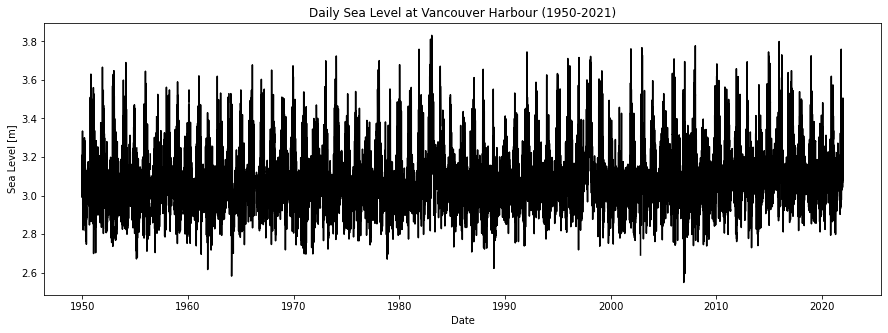

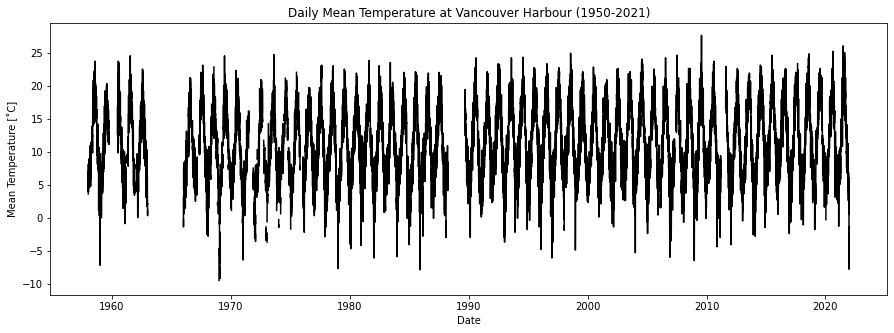

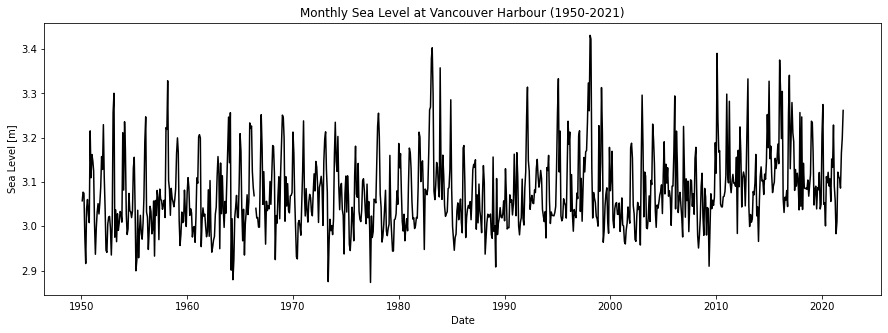

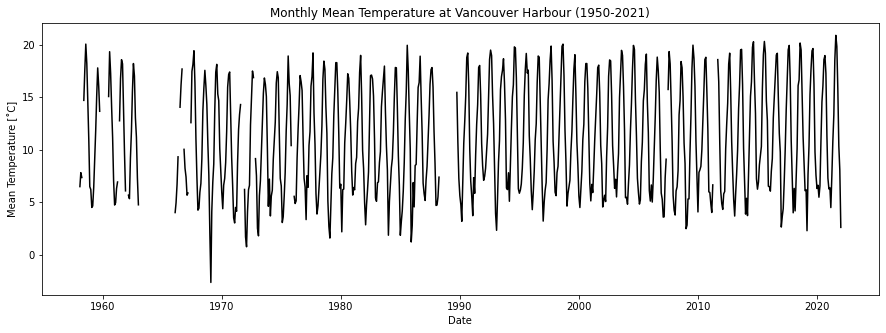

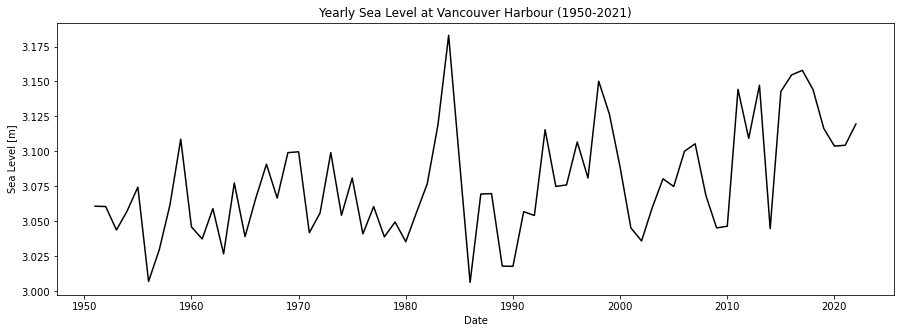

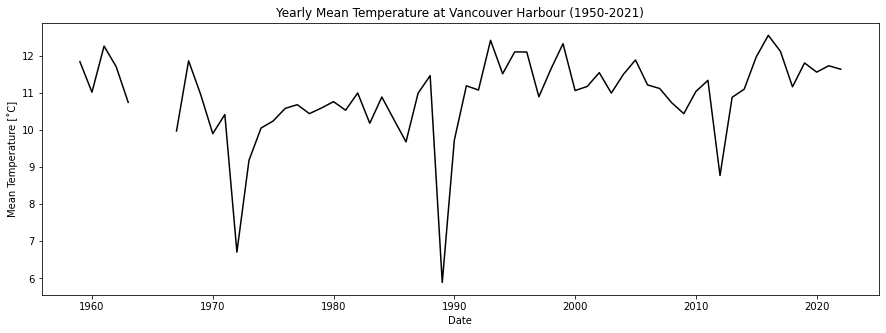

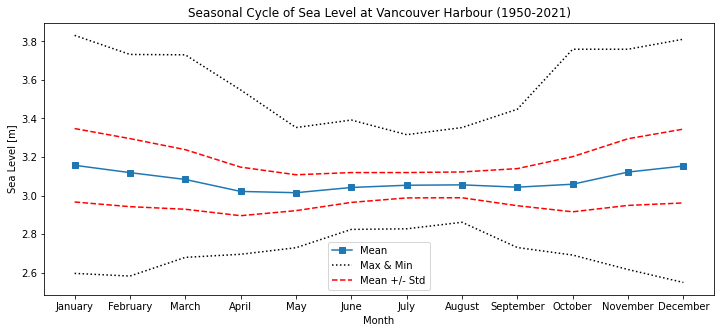

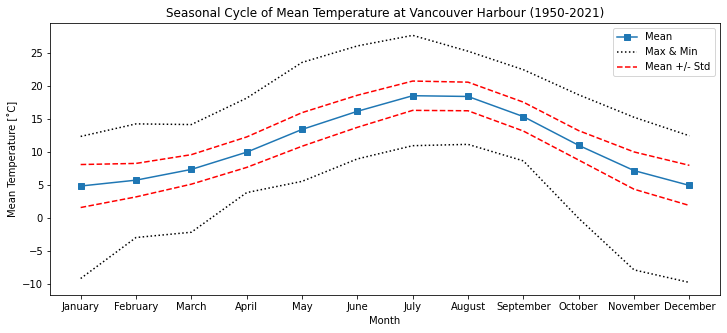

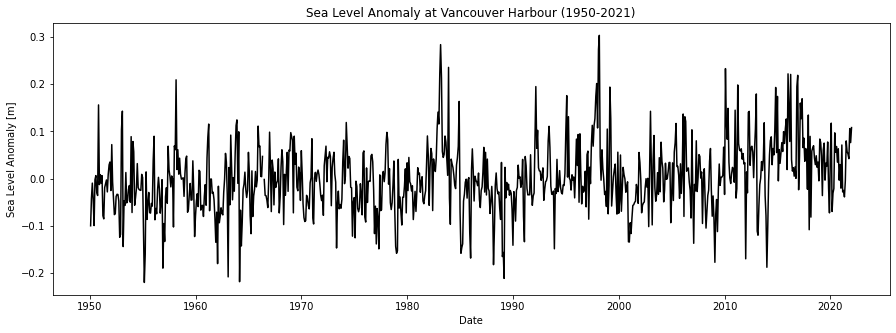

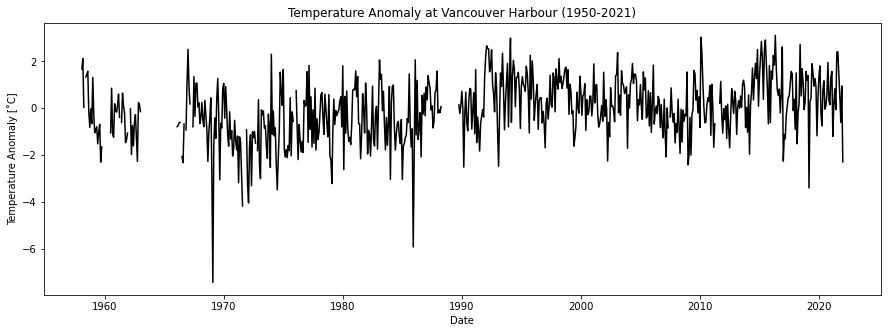

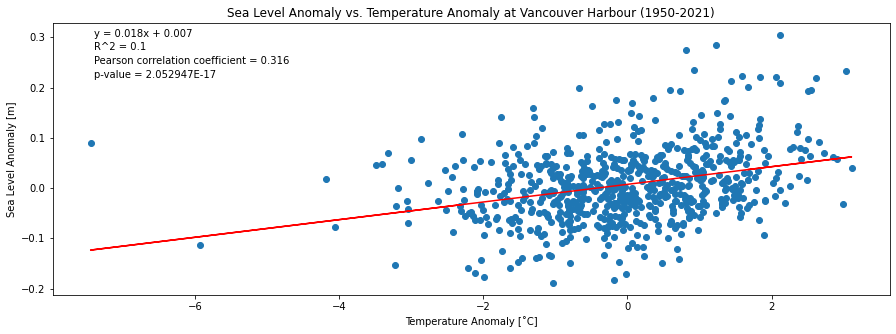

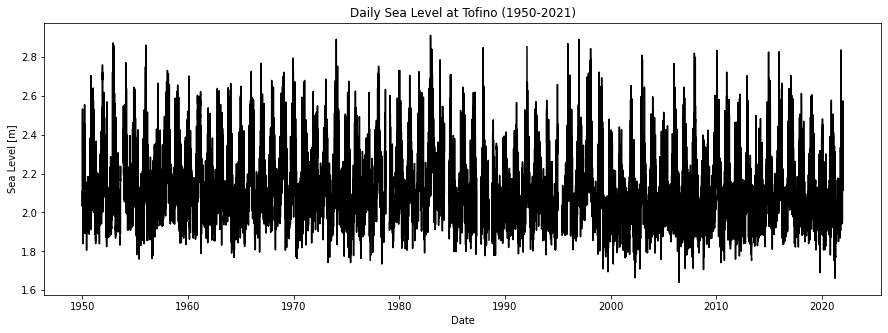

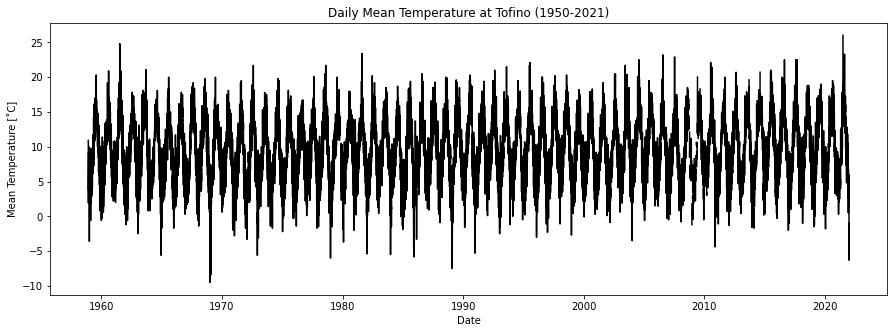

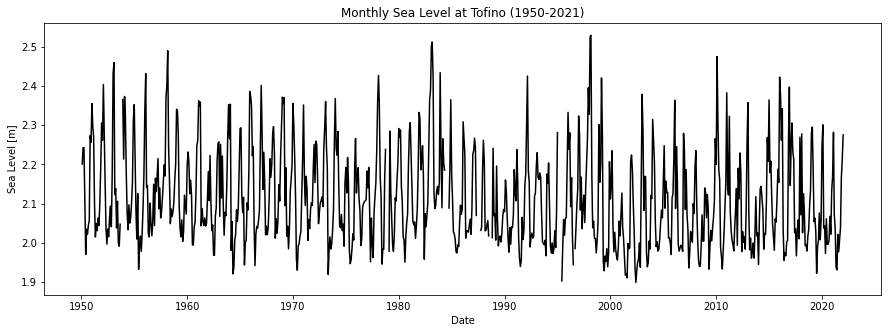

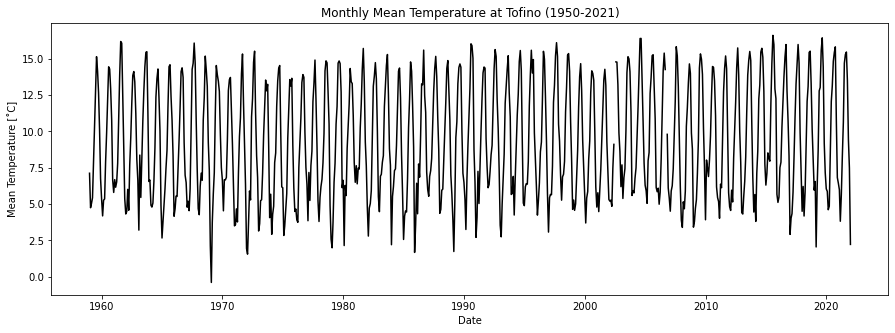

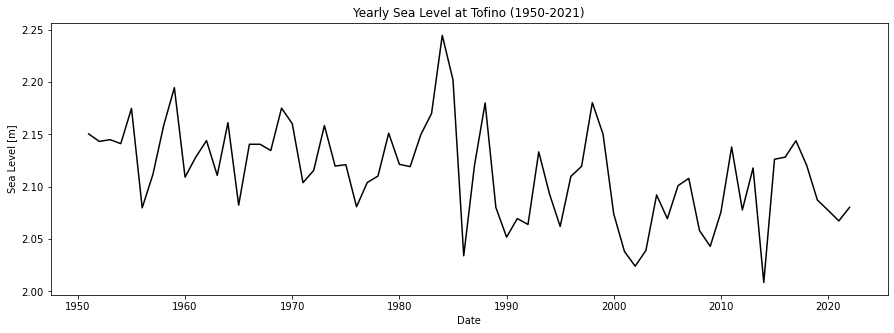

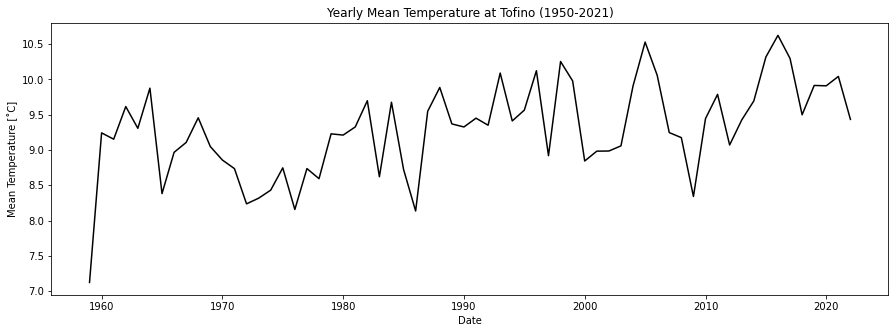

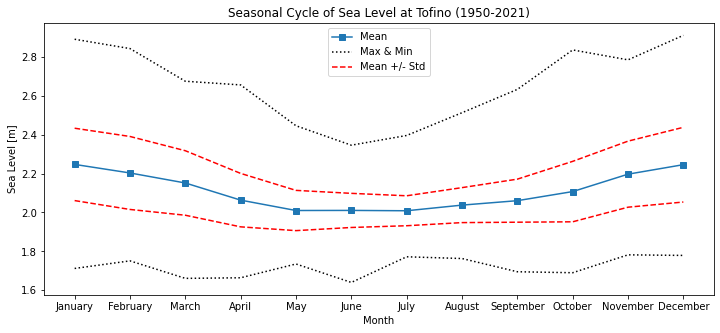

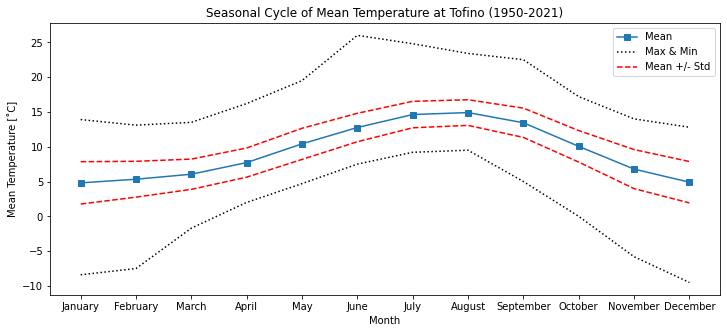

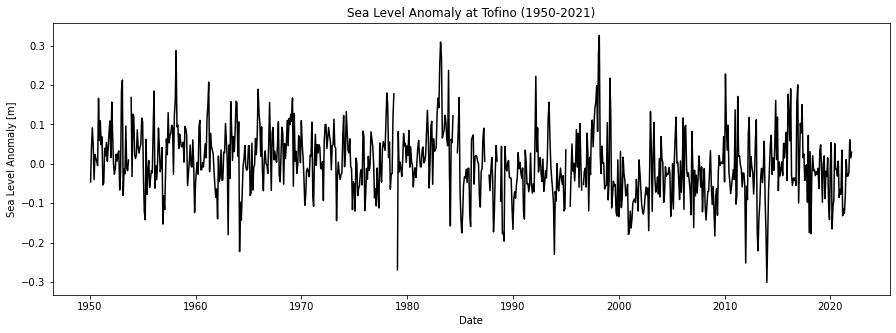

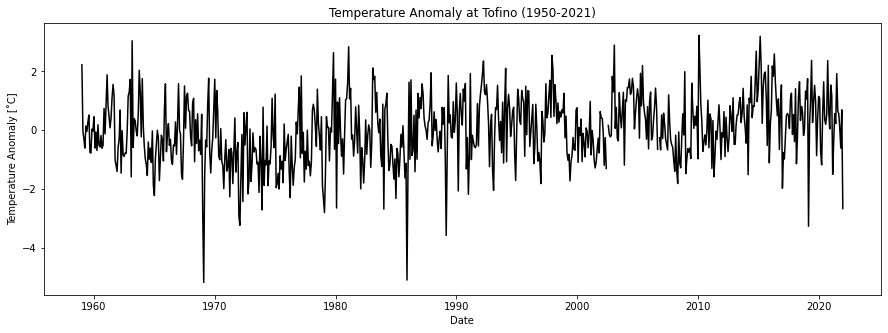

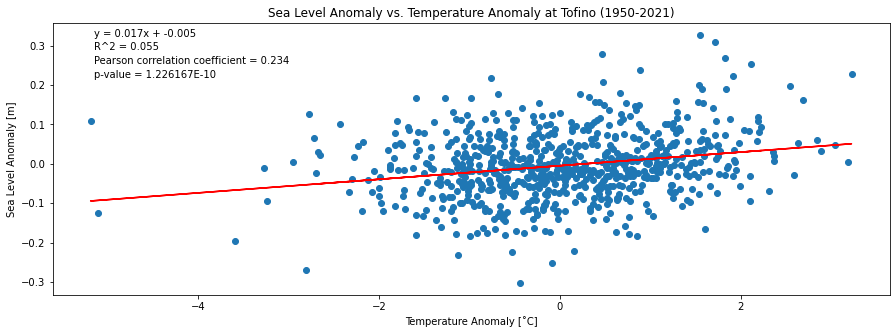

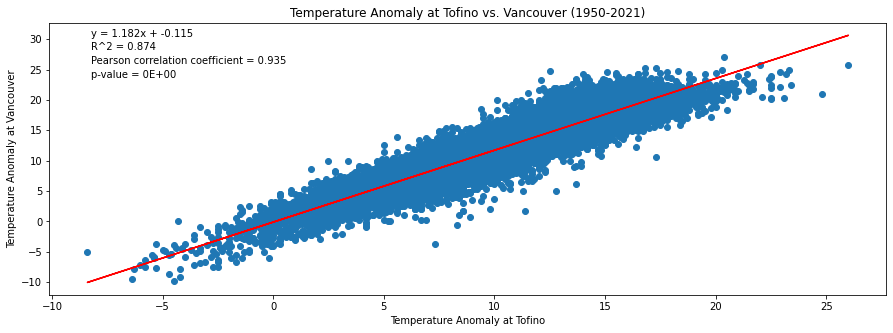

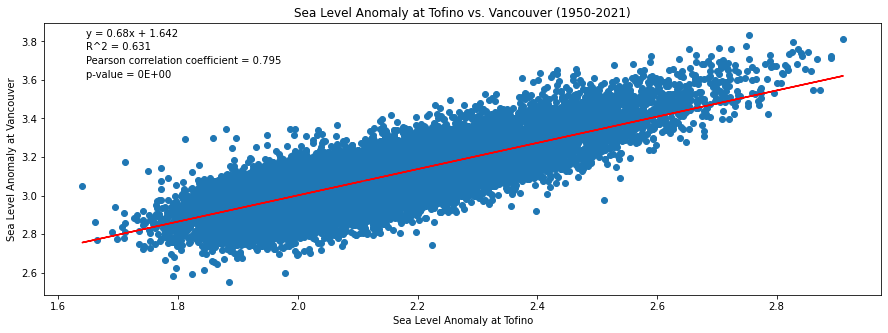

In [151]:
plot_all(df_SOB_van, 'Vancouver Harbour')
plot_all(df_SOB_tofino, 'Tofino')
plot_correlation(df_SOB_tofino['MeanTemp'], df_SOB_van['MeanTemp'], 'Temperature Anomaly at Tofino vs. Vancouver' + date_range_str, 'Temperature Anomaly at Tofino', 'Temperature Anomaly at Vancouver')
plot_correlation(df_SOB_tofino['sealevel'], df_SOB_van['sealevel'], 'Sea Level Anomaly at Tofino vs. Vancouver' + date_range_str, 'Sea Level Anomaly at Tofino', 'Sea Level Anomaly at Vancouver')

start_index:  0
end_index:  14608
start_index:  14610
end_index:  18260
start_index:  18262
end_index:  21913
start_index:  21915
end_index:  25565


<ipython-input-152-0bf820a85ea7>:150: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


start_index:  0
end_index:  14608
start_index:  14610
end_index:  18260
start_index:  18262
end_index:  21913
start_index:  21915
end_index:  25565


<ipython-input-152-0bf820a85ea7>:158: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


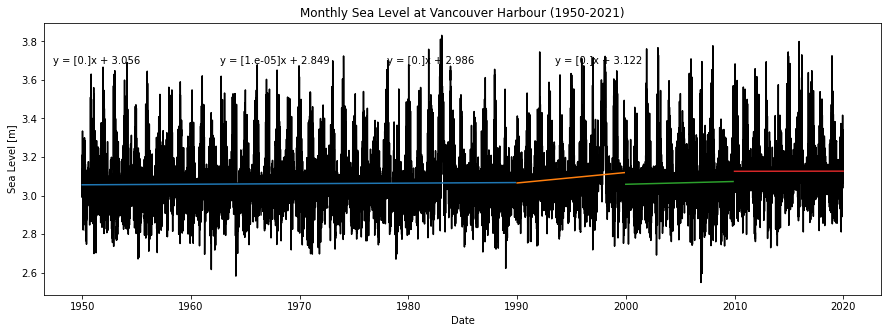

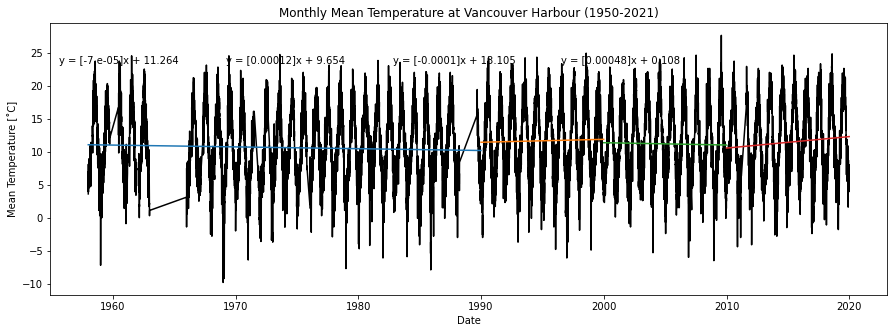

In [152]:
# groupByDF2_monthly = tempDataDF.groupby(pd.PeriodIndex(tempDataDF.Date.dt.to_period('M')))["MeanTemp"] # JH: Group data by month over 1959-2018

# original_monthly_temp_mean = groupByDF2_monthly.mean() # JH: Get group's mean
# monthly_temp_mean = original_monthly_temp_mean.to_frame() # JH: Have to make it a dataframe to use function below
# monthly_temp_mean = monthly_temp_mean.reset_index() # JH: Fix things behind the scenes silly python
# monthly_dates_full = monthly_temp_mean["Date"].dt.to_timestamp() # JH: Get the x values which is all of the months

# sea_month = df.groupby(df.Date.dt.to_period('M'))['sealevel'].mean()
# sea_month = sea_month.to_frame()
# sea_month = sea_month.reset_index()
# # covert sea_month to a pandas dataframe
# monthly_sea_level = sea_month['sealevel']
# months = sea_month['Date'].dt.to_timestamp()



# def plot_range_linear_regression_2(df, start_date, end_date, x_name, y_name, title, xlabel, ylabel, iteration):
#     loc_df = df.loc[start_date:end_date]
    
#     groupByDF2_monthly = loc_df.groupby(pd.PeriodIndex(loc_df.Date.dt.to_period('M')))["MeanTemp"] # JH: Group data by month over 1959-2018

#     original_monthly_temp_mean = groupByDF2_monthly.mean() # JH: Get group's mean
#     monthly_temp_mean = original_monthly_temp_mean.to_frame() # JH: Have to make it a dataframe to use function below
#     monthly_temp_mean = monthly_temp_mean.reset_index() # JH: Fix things behind the scenes silly python
    
#     dates = monthly_temp_mean["Date"].dt.to_timestamp().index.values
#     values = monthly_temp_mean[y_name].values
    
    
#     # df_monthly = loc_df.groupby(pd.Grouper(key=x_name, freq='M')).mean()
#     # dates = monthly_dates_full.index.values
#     # values = monthly_dates_full[y_name].values #df_monthly[y_name][start_date:end_date]
    
#     dates_reshaped = dates.reshape(-1,1)
#     values_reshaped = values.reshape(-1,1)
    
#     values_reg = LinearRegression().fit(dates_reshaped, values_reshaped)

#     values_pred = values_reg.predict(dates_reshaped) # JH: Predict using ubc_dates
    
#     values_trend = np.array2string(np.around(values_reg.coef_[0], decimals=5))
#     values_r2 = np.array2string(np.around(values_reg.score(dates_reshaped, values_reshaped), decimals=3))
    
#     plt.plot(dates, values_reshaped, '-', color='black' )
#     plt.plot(dates, values_pred)
#     plt.annotate('Trend: ' + values_trend + '\u00b0C/yr$R^2$: ' + values_r2, xy=(0.01 + 0.2*iteration, 0.85), xycoords='axes fraction', color='r')
    
#     plt.title(title)
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)

from datetime import datetime as dt
from datetime import date, timedelta
import time

def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction


def plot_range_linear_regression(df, start_year, end_year, x_name, y_name, title, xlabel, ylabel, iteration):
    start_index = 0
    end_index = 0
    for index, row in df.iterrows():
        if (row[x_name].year == start_year):
            start_index = index
            break
    for index, row in df.iterrows():
        if (row[x_name].year + 1 == end_year):
            end_index = index - 1
    
    print("start_index: ", start_index)
    print("end_index: ", end_index)
    
    locDF = df.loc[start_index:end_index]

    # locDF_monthly = locDF.groupby(pd.Grouper(key=x_name, freq='M')).mean()
    # dates = loc[x_name].values
    
    
    
    # groupByDF2_monthly = locDF.groupby(pd.PeriodIndex(locDF.Date.dt.to_period('M')))[y_name]

    # original_monthly_temp_mean = groupByDF2_monthly.mean()
    # locDF_monthly = original_monthly_temp_mean.to_frame()
    # locDF_monthly = locDF_monthly.reset_index()
    
    # dates = locDF_monthly["Date"].dt.to_timestamp().index.values
    # values = locDF_monthly[y_name].values
    
    
    
    values = locDF[y_name].values #df_monthly[y_name][start_date:end_date]
    dateIndices = locDF.index.values
    dates = locDF[x_name].values
    
    values_mask = np.isnan(values) | np.isnan(dateIndices)
    
    values_masked = values[~values_mask]
    dateIndices_masked = dateIndices[~values_mask]
    dates_masked = dates[~values_mask]
    
    dateIndices_reshaped = dateIndices_masked.reshape(-1,1)
    values_reshaped = values_masked.reshape(-1,1)
    dates_reshaped = dates_masked.reshape(-1,1)
    
    model = LinearRegression().fit(dateIndices_reshaped, values_reshaped)
    values_pred = model.predict(dateIndices_reshaped)
    
    values_trend = np.array2string(np.around(model.coef_[0], decimals=5))
    values_r2 = np.array2string(np.around(model.score(dateIndices_reshaped, values_reshaped), decimals=3))
    
    r2 = np.round(r2_score(values_reshaped, values_pred), 3)
    gradient = np.round(model.coef_[0][0], 3)
    intercept = np.round(model.intercept_[0], 3)
    
    plt.plot(dates_reshaped, values_reshaped, '-', color='black' )
    plt.plot(dates_reshaped, values_pred)
    # plt.annotate('Trend: ' + values_trend + '\u00b0C/yr$R^2$: ' + values_r2, xy=(0.01 + 0.2*iteration, 0.85), xycoords='axes fraction', color='r')
    
    plt.annotate('y = ' + values_trend + 'x + ' + str(intercept), xy=(0.01 + 0.2*iteration, 0.85), xycoords='axes fraction')
    
    # plt.annotate('R^2 = ' + str(r2), xy=(0.05, 0.90), xycoords='axes fraction')
    # plt.annotate(f'Pearson correlation coefficient = {corr:.3f}', xy=(0.05, 0.85), xycoords='axes fraction')
    # plt.annotate(f'p-value = {format_e(pval)}', xy=(0.05, 0.80), xycoords='axes fraction')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

stationName = 'yay'

plt.figure(figsize=(15, 5))
plot_range_linear_regression(df_SOB_van, 1940, 1990, 'Date', 'sealevel', 'Monthly Sea Level at ' + 'Vancouver Harbour' + date_range_str, 'Date', 'Sea Level [m]', 0)
plot_range_linear_regression(df_SOB_van, 1990, 2000, 'Date', 'sealevel', 'Monthly Sea Level at ' + 'Vancouver Harbour' + date_range_str, 'Date', 'Sea Level [m]', 1)
plot_range_linear_regression(df_SOB_van, 2000, 2010, 'Date', 'sealevel', 'Monthly Sea Level at ' + 'Vancouver Harbour' + date_range_str, 'Date', 'Sea Level [m]', 2)
plot_range_linear_regression(df_SOB_van, 2010, 2020, 'Date', 'sealevel', 'Monthly Sea Level at ' + 'Vancouver Harbour' + date_range_str, 'Date', 'Sea Level [m]', 3)
plt.savefig("graphs/" + "Linear_" + 'Monthly Sea Level at ' + 'Vancouver Harbour' + '.png', dpi=300, bbox_inches="tight")
plt.show()

plt.figure(figsize=(15, 5))
plot_range_linear_regression(df_SOB_van, 1940, 1990, 'Date', 'MeanTemp', 'Monthly Mean Temperature at ' + 'Vancouver Harbour' + date_range_str, 'Date', 'Mean Temperature [˚C]', 0)
plot_range_linear_regression(df_SOB_van, 1990, 2000, 'Date', 'MeanTemp', 'Monthly Mean Temperature at ' + 'Vancouver Harbour' + date_range_str, 'Date', 'Mean Temperature [˚C]', 1)
plot_range_linear_regression(df_SOB_van, 2000, 2010, 'Date', 'MeanTemp', 'Monthly Mean Temperature at ' + 'Vancouver Harbour' + date_range_str, 'Date', 'Mean Temperature [˚C]', 2)
plot_range_linear_regression(df_SOB_van, 2010, 2020, 'Date', 'MeanTemp', 'Monthly Mean Temperature at ' + 'Vancouver Harbour' + date_range_str, 'Date', 'Mean Temperature [˚C]', 3)
plt.savefig("graphs/" + "Linear_" + 'Monthly Mean Temperature at ' + 'Vancouver Harbour' + '.png', dpi=300, bbox_inches="tight")
plt.show()